# 准备

## 库 导入

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scikit-learn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from scikit-learn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
warnings.filterwarnings('ignore')

In [152]:
from scikit-learn.model_selection import train_test_split
from scikit-learn.feature_selection import SelectKBest
from scikit-learn.feature_selection import chi2
from scikit-learn.feature_selection import f_classif
from scikit-learn.feature_selection import mutual_info_classif
from scikit-learn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,SGDClassifier,RidgeClassifierCV
from scikit-learn.svm import SVC, LinearSVC, NuSVC

## 基础设置

In [3]:
GSE_Train = "GSE63990" # 用于训练的数据集
Skip_Paint = True # 是否绘制不必要的绘图


In [154]:
methods = [chi2, f_classif, mutual_info_classif]
models = [
    LinearRegression(), 
    RidgeClassifierCV(class_weight='balanced'),
    LogisticRegression(),
    Lasso(),
    LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        C=0.01,
        max_iter=10000,
        multi_class='ovr',
        fit_intercept=True,
        intercept_scaling=1,
        class_weight='balanced',
        verbose=0,
        random_state=0,
        tol=1e-4
    ),
    NuSVC(kernel='linear',
        max_iter=10000)
]
n_features = [i for i in range(1, 16)]

## 数据 导入

In [5]:
GPL571 = GEOparse.get_GEO(geo="GPL571", destdir="./datasets", silent=True)

In [6]:
gse = GEOparse.get_GEO(geo=GSE_Train, destdir="./datasets", silent=True)
gpls = gse.metadata['platform_id']
gpl = GEOparse.get_GEO(geo=gpls[0], destdir="./datasets", silent=True)
gse_csv = pd.read_csv('./datasets/' + GSE_Train + '.csv')
gse_csv.head() # 预览数据

,gsm,infection_status,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Bs-thr-M_s_at,AFFX-r2-Ec-bioB-3_at,AFFX-r2-Ec-bioB-5_at,AFFX-r2-Ec-bioB-M_at,AFFX-r2-Ec-bioC-3_at,AFFX-r2-Ec-bioC-5_at,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at
0,['GPL571'],non-infectious illness,107.026284,158.817338,2545.754898,186.244424,13.132469,643.402073,34.615676,17.490946,...,17.173226,422.464901,566.805882,481.918815,1421.477295,1302.020303,6250.362334,3836.600257,17740.725022,14961.589573
1,['GPL571'],non-infectious illness,221.020421,124.644738,2143.929143,324.223899,15.427804,1001.622909,49.833883,22.848206,...,17.962223,652.117965,800.852865,822.133404,2305.851262,2008.050881,8731.397156,5399.129367,19067.890695,17285.989865
2,['GPL571'],non-infectious illness,137.091142,115.353642,1741.194207,299.526479,13.588461,549.283988,47.869510,18.544460,...,17.282754,483.392556,566.237470,586.430031,1792.943487,1330.467773,7401.441597,4578.962962,18303.281696,15753.041045
3,['GPL571'],non-infectious illness,126.175162,98.119250,1316.526914,326.999326,12.738011,339.984798,51.808930,19.624606,...,17.651712,1275.694498,1781.291882,1547.788940,3845.464156,3549.057271,11770.475723,7924.052042,23370.081259,19856.779557
4,['GPL571'],bacterial,105.348086,260.359324,2930.300695,223.766173,12.436344,409.723526,35.071703,19.844859,...,18.275624,404.702873,518.880900,477.676689,1299.615932,1186.047735,5968.686731,3780.851630,18440.196387,15535.017110


In [7]:
gse_csv.isnull().sum() 

gsm                     0
infection_status        0
1007_s_at               0
1053_at                 0
117_at                  0
                       ..
AFFX-r2-Ec-bioC-5_at    0
AFFX-r2-Ec-bioD-3_at    0
AFFX-r2-Ec-bioD-5_at    0
AFFX-r2-P1-cre-3_at     0
AFFX-r2-P1-cre-5_at     0
Length: 22279, dtype: int64

In [8]:
gse_csv['infection_status'].value_counts() # 看一下感染这个列的分布

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

## 函数 准备

In [9]:
def is_prime_factors_only(n, allowed_factors):
    for factor in allowed_factors:
        while n % factor == 0:
            n //= factor
    return n == 1

def get_allowed_numbers(max_n=25,allowed_factors=[2,3,5]):
    result = []
    for i in range(1, max_n + 1):
        if is_prime_factors_only(i, allowed_factors):
            result.append(i)
    return result

def is_all_in_list(list,n=25,allowed_factors=[2,3,5]):
    for i in list:
        if i not in get_allowed_numbers(n,allowed_factors):
            return False
    return list

In [10]:
def plot_score_distribution(ax, y_score, final_target):                                 # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_target, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    labels = ['细菌感染', '病毒感染']                                                   # 图例标签，这里是感染情况，以后如果换了的话得改。 #todo 将这个改为传入参数
    ax.legend(labels, loc='upper right')                                                # 图例
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数

def plot_roc_curve(ax, y_score, final_target):
    from scikit-learn.metrics import auc
    fpr, tpr, thresholds = roc_curve(final_target, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

def plot_pr_curve(ax, y_score, final_target):
    precision, recall, thresholds = precision_recall_curve(final_target, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

def plot_confusion_matrix(ax, y_score, final_target):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_target, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues)
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['病毒感染', '细菌感染'], rotation=45)
    plt.yticks(tick_marks, ['病毒感染', '细菌感染'])
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

def plot_all(score, target, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))                                                     # 规定画布大小为1200*1200px，分成2*2的4个小图
    fig.suptitle(title, fontsize=16)                                                                    # 设置标题
    plot_score_distribution(axs[0,0], score, target)                                                    # 第一个小图（左上角）是分数分布图 这里的axs[0,0]是指第一行第一列的小图，注意计数是从0开始的。
    plot_roc_curve(axs[0,1], score, target)                                                             # 第二个小图（右上角）是ROC曲线
    plot_pr_curve(axs[1,0], score, target)                                                              # 第三个小图（左下角）是PR曲线
    plot_confusion_matrix(axs[1,1], score, target)                                                      # 第四个小图（右下角）是混淆矩阵
    if feature or weight:                                                                               # 如果有feature或者weight的话，就在图的下方加上文字
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)                                                            # 调整图的下边距，这样文字就不会挡住图了
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)          # 同上
        except:
            pass                                                                                        # 如果出错了就算了
    return fig, axs

def testfeature(feature,weight,data,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimes(feature,weight,data,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    try:
        target = data['infection_status'].values
    except:
        target = gse_csv['infection_status']
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)

def testfeaturewithtimesandtarget(feature,weight,data,target,times=1,gpl=gpl,title="分数分布图、ROC曲线、PR曲线和混淆矩阵"):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    testdata = data[ID]
    n = len(testdata)
    y_score = np.zeros(n)
    y_pred = np.zeros(n)
    for i in range(len(testdata)):
        y_score [i] = np.dot(testdata.iloc[i],weight)
        # 结果除以times
        y_score [i] = y_score [i] / times
        y_pred [i] = np.where(y_score[i] > 0.5, 1, 0)
    acc = accuracy_score(target, y_pred)
    print("Accuracy: ", acc)
    fig, axs = plot_all(y_score, target, title, feature=feature, weight=weight)


In [11]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        # reselect the features
        reselect = SelectKBest(score_func=method, k=i)
        reselect.fit(X_train, y_train)
        model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
        y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
        train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
        test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
        train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
        test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
    X_train_new = select.transform(X_train)
    X_test_new = select.transform(X_test)
    model.fit(X_train_new, y_train)
    y_pred = model.predict(X_test_new)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的准确率为：', model.score(X_test_new, y_test))
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的AUC为：', roc_auc_score(y_test, y_pred))
    # # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的权重为：', model.coef_)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的截距为：', model.intercept_)
    # get column names
    gene_id = X_train.columns[select.get_support(indices=True)]
    gene_id = np.array(gene_id).reshape(-1)
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


In [12]:
def find_best_n(ax,X_train, y_train, X_test, y_test, method, model, max_features=20):
    train_acc,test_acc,train_roc,test_roc = [],[],[],[]
    for i in range(1, max_features):
        if method == 'mannual':
            reselect = X_train.iloc[:, :i]
            model.fit(reselect, y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, :i])
            train_acc.append(model.score(reselect, y_train))
            test_acc.append(model.score(X_test.iloc[:, :i], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(reselect)))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, :i])))
        else:
            reselect = SelectKBest(score_func=method, k=i)
            reselect.fit(X_train, y_train)
            model.fit(X_train.iloc[:, reselect.get_support(indices=True)], y_train) # use the selected features to train the data
            y_pred = model.predict(X_test.iloc[:, reselect.get_support(indices=True)])
            train_acc.append(model.score(X_train.iloc[:, reselect.get_support(indices=True)], y_train))
            test_acc.append(model.score(X_test.iloc[:, reselect.get_support(indices=True)], y_test))
            train_roc.append(roc_auc_score(y_train, model.predict(X_train.iloc[:, reselect.get_support(indices=True)])))
            test_roc.append(roc_auc_score(y_test, model.predict(X_test.iloc[:, reselect.get_support(indices=True)])))
    # ax.plot(range(1, max_features), train_acc, label='train_acc')
    ax.plot(range(1, max_features), test_acc, label='test_acc')
    # ax.plot(range(1, max_features), train_roc, label='train_roc')
    ax.plot(range(1, max_features), test_roc, label='test_roc')
    if method == 'mannual':
        ax.set_title('使用'+str(model) + '按照表达比选择特征')
    else:
        ax.set_title('使用'+str(model) + '和' + method.__name__ + '选择特征')
    plt.rcParams['font.sans-serif'] = ['SimHei']
    ax.legend()
    # grid
    ax.grid()
    # mark the maximum value
    ax.scatter(test_acc.index(max(test_acc)) + 1, max(test_acc), marker='o', color='b')
    ax.text(test_acc.index(max(test_acc)) + 1, max(test_acc), str(test_acc.index(max(test_acc)) + 1) + ', ' + str('%.2f%%' % (max(test_acc) * 100)))
    ax.scatter(test_roc.index(max(test_roc)) + 1, max(test_roc), marker='o', color='r')
    ax.text(test_roc.index(max(test_roc)) + 1, max(test_roc), str(test_roc.index(max(test_roc)) + 1) + ', ' + str('%.2f%%' % (max(test_roc) * 100)))
    # y is 0.5 to 1
    ax.set_ylim(0.5, 1)

    if method != 'mannual':
        select = SelectKBest(score_func=method, k=test_acc.index(max(test_acc)) + 1).fit(X_train, y_train)
        X_train_new = select.transform(X_train)
        X_test_new = select.transform(X_test)
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train.columns[select.get_support(indices=True)]
    else:
        X_train_new = X_train.iloc[:, :test_acc.index(max(test_acc)) + 1]
        X_test_new = X_test.iloc[:, :test_acc.index(max(test_acc)) + 1]
        model.fit(X_train_new, y_train)
        y_pred = model.predict(X_test_new)
        gene_id = X_train_new.columns
    gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征为：', gene_symbol)
    # print('使用' + str(model) + '和' + method.__name__ + '选择特征后的特征权重为：', model.coef_)
    
    n = test_acc.index(max(test_acc)) + 1
    best_acc = max(test_acc)

    return best_acc, n, gene_symbol, model.coef_


In [13]:
def predict(model, X, time=None):
    # if not coef: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
    if time is not None:
        coef = model.coef_.ravel() * time
        coef = np.round(coef)
        time = float(time)
    else:
        time = 1
        time = float(time)
        coef = model.coef_.ravel()
    if model.__class__.__name__ == 'LinearRegression':
        y_pred = float(np.dot(X, coef))/time + model.intercept_ 
    elif model.__class__.__name__ == 'RidgeClassifier':
        y_pred = np.dot(X, coef)/time + model.intercept_ + 0.5# 以0为分界（？
    elif model.__class__.__name__ == 'LogisticRegression':
        z = np.dot(X, coef)/time + model.intercept_
        y_pred = 1 / (1 + np.exp(-z))
        # y_pred = np.dot(X, model.coef_.ravel()) + model.intercept_
    elif model.__class__.__name__ == 'LinearSVC':
        y_pred = np.dot(X, coef)/time + model.intercept_
    elif model.__class__.__name__ == 'NuSVC':
        y_pred = np.dot(X, coef) / time + model.intercept_ + 0.5 # 以0为分界（？
    else:
        y_pred = model.predict(X)
    return y_pred

In [78]:
def cal_score(feature, weight, times, data, model, intercept):
    score = []
    indexs = []
    for i in range(len(feature)):
        id = gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0]
        index = data.columns.get_loc(id)
        indexs.append(index)
    for i in range(len(data)):
        # if model is in LinearRegression, LinearSVC
        if model == model.__class__.__name__ == 'LinearRegression' or model.__class__.__name__ == 'LinearSVC':  
            score.append(
                np.dot(
                    data.iloc[i, indexs].values,weight
                    )/times
                )
        elif model == model.__class__.__name__ in ['RidgeClassifier','NuSVC','RidgeClassifierCV']:
            score.append(
                np.dot(
                    data.iloc[i, indexs].values,weight
                    )/times + 0.5
                )
        elif model == model.__class__.__name__ == 'LogisticRegression':
            z = np.dot(
                data.iloc[i, indexs].values,weight
            )/times  + intercept
            
            score.append(1/(1+np.exp(-z)))
        else:
            z = np.dot(
                data.iloc[i, indexs].values,weight
            )/times  + intercept
            score.append(1 / (1 + np.exp(-z)))

    return score

In [15]:
def test_method(select_method, model, n_feature, X_train, X_test, y_train, y_test):
    success = False
    reselect = SelectKBest(score_func=select_method, k=n_feature)
    reselect.fit(X_train, y_train)
    X_train_new = reselect.transform(X_train)
    X_test_new = reselect.transform(X_test)
    model.fit(X_train_new, y_train)
    y_score= predict(model, X_test_new)
    y_pred = model.predict(X_test_new)
    model_acc = np.mean(np.equal(y_pred, y_test))
    title = '使用' + select_method.__class__.__name__ + '选择' + str(n_feature) + '个特征的' + model.__class__.__name__ + '的直接运算的预测结果'
    gene_id = X_train.columns[reselect.get_support(indices=True)]
    feature = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
    print('使用 ' + select_method.__name__ + ' 选择特征和 ' + str(model) + ' 训练模型，准确率为', '%.2f%%' % (model_acc * 100))
    print('截距：', model.intercept_ , ' 选出基因： ', feature)


    coef = model.coef_
    weights_avg = np.mean(coef)
    # 使coef中最小的为1需要的倍数
    min_times = 0.5 / np.min(coef)
    max_times = 25 / np.max(coef)
    print('min',min_times,'max',max_times)
    # times = np.logspace(1, 10, num=5000, base=10)
    times = np.linspace(min_times, max_times, num=10000)
    all_coef = []
    good_coef = []
    differences = []
    for time in times:
        coef_rounded = np.round(coef.ravel() * time).tolist()
        coef_rounded = [int(i) for i in coef_rounded]
        if is_all_in_list(coef_rounded) and coef_rounded not in all_coef:
            all_coef.append(coef_rounded)
            y_score = predict(model, X_test_new, time)
            y_pred = np.array([1 if i > 0.5 else 0 for i in y_score], dtype=int)
            acc = np.mean(y_pred == y_test)
            if np.mean(acc) == model_acc:
                actual_time = np.mean(coef.ravel() * time) / weights_avg
                difference = np.mean(np.abs(np.array(coef_rounded) - np.array(coef.ravel() * time))) / np.mean(np.abs(np.array(coef_rounded)))
                differences.append(difference)
                good_coef.append(coef_rounded)
                success = True
                print('coef =', coef_rounded,'time =', '%.2f' % actual_time,' difference:', '%.2f%%' % (difference*100))
        else:
            pass
    if success:
        best_index = differences.index(min(differences))
        best_coef = good_coef[best_index]
        best_time = np.mean(best_coef) / weights_avg
        print("="*60)
        print('best coef =', best_coef,'best time =', '%.2f' % best_time)
    else:
        print('没有找到合适的倍数')
        best_coef = coef
        best_time = 1
    plot_all(
        score = y_score,
        target = y_test,
        title = title,
        feature = feature,
        weight = best_coef)
    plt.show()

    coef = model.coef_

    return coef, reselect

In [16]:
def plot_boxplot(data_higher, gpl, gse_csv, data_higher_times):
    fig, ax = plt.subplots(1,50, figsize=(50,15))
    for i in range(50):
        sns.boxplot(
            x='infection_status', 
            y=data_higher.iloc[:,i],
            data=gse_csv,
            ax=ax[i],
            )
        ax[i].set_title(gpl.table[gpl.table['ID'] == data_higher.columns[i]]['Gene Symbol'].values[0])

        # 最上面加上对应的倍数
        ax[i].text(0.1, 0.98,
                   str('%.2f' % data_higher_times[i]),
                   transform=ax[i].transAxes,
                   fontsize=16,
                   verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

        # 显示优化
        ax[i].set_yscale('log') #对数坐标
        ax[i].set_ylim(10, 40000) # y轴的范围
        if i != 0: # 不显示x，y轴的标签， 不然太挤了没意义
            ax[i].set_xlabel('')
            ax[i].set_yticklabels([])
            ax[i].set_ylabel('')
            ax[i].set_yticks([])
        else:
            ax[i].set_xlabel('')
            ax[i].set_ylabel('表达量')
        ax[i].tick_params(axis='x', rotation=90) # 不然画不下
    plt.show()

In [50]:
def get_higher_columns(data):
    data_mean = data.groupby('target').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if data_mean.iloc[1,i] > 2*data_mean.iloc[0,i] or 2*data_mean.iloc[0,i] < data_mean.iloc[1,i]:
            higher_columns.append(data_mean.columns[i])
            higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

In [18]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add target column to the top of data_higher_columns
    data_higher_columns.append('target')
    data_higher_columns.append('infection_status')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

In [19]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

In [20]:
def get_symbols(gene_symbols):
    gene_symbols = gene_symbols.reset_index(drop=True)
    symbol = []
    for i in range(len(gene_symbols)):
        for j in range(len(gene_symbols[i])):
            if gene_symbols[i][j] not in symbol:
                symbol.append(gene_symbols[i][j])
            else:
                pass
    return symbol


In [64]:
# input: methods, models, n_features, X_train, X_test, y_train, y_test, gpl
# output: results


def test_all(methods, models, n_features, X_train, X_test, y_train, y_test, gpl):
    import time
    results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'confusionmatrix',
                                    'coef', 'coef_rounded', 'found_coef', 'multiple_times',
                                    'intercept', 'gene_id', 'gene_symbol', 'gb_acc'
                                    ])
    for method in methods:
        for n in n_features:
            reselect = SelectKBest(score_func=method, k=n)
            reselect.fit(X_train, y_train)
            for model in models:
                # log the time
                time_start = time.time()
                model.fit(reselect.transform(X_train), y_train)
                y_score = model.predict(reselect.transform(X_test))
                y_pred = np.array([1 if i > 0.5 else 0 for i in y_score], dtype=int)
                acc = accuracy_score(y_test, y_pred)
                auc = roc_auc_score(y_test, model.predict(reselect.transform(X_test)))
                f1 = f1_score(y_test, y_pred)
                precision = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                confusionmatrix = confusion_matrix(y_test, y_pred)
                coef = model.coef_

                weights_avg = np.mean(coef)
                min_times = 0.5 / np.min(np.abs(coef)) if np.min(coef) != 0 else 0.5 / np.mean(np.abs(coef))
                max_times = 25 / np.max(np.abs(coef))
                multipletimes = np.linspace(min_times, max_times, num=1000)
                found_coef = False
                coef_roundeds = []
                differences = []
                for multipletime in multipletimes:
                    coef_rounded = np.round(coef.ravel() * multipletime).tolist()
                    try:
                        coef_rounded = [int(i) for i in coef_rounded]
                        abs_coef_rounded = [abs(i) for i in coef_rounded]
                        if is_all_in_list(abs_coef_rounded):
                            coef_roundeds.append(coef_rounded)
                            difference = np.mean(np.abs(np.array(coef_rounded) - np.array(coef.ravel() * multipletime))) / np.mean(np.abs(np.array(coef_rounded)))
                            differences.append(difference)
                            found_coef = True
                        else:
                            pass
                    except:
                        pass
                if not found_coef:
                    coef_rounded = np.round(100 * coef.ravel() / weights_avg).tolist()
                    try:
                        coef_rounded = [int(i) for i in coef_rounded]
                    except:
                        pass
                    multiple_time = 100
                else:
                    best_index = differences.index(min(differences))
                    coef_rounded = coef_roundeds[best_index]
                    multiple_time = np.mean(np.abs(coef_rounded)) / np.mean(np.abs(coef.ravel()))
                    # is all > 0
                    # if not all(i > 0 for i in coef_rounded):
                    #     found_coef = False

                intercept = model.intercept_
                gene_id = X_train.columns[reselect.get_support(indices=True)]
                gene_id = np.array(gene_id).reshape(-1)
                gene_symbol = [gpl.table[gpl.table['ID'] == i]['Gene Symbol'].values[0] for i in gene_id]
                gb_acc = [gpl.table[gpl.table['ID'] == i]['GB_ACC'].values[0] for i in gene_id]
                results = results.append({
                    'method': method.__name__,
                    'model': model.__class__.__name__,
                    'n': n,
                    'acc': acc,
                    'auc': auc,
                    'f1': f1,
                    'precision': precision,
                    'recall': recall,
                    'confusionmatrix': confusionmatrix,
                    'coef': coef,
                    'coef_rounded': coef_rounded,
                    'found_coef': found_coef,
                    'multiple_times': multiple_time,
                    'intercept': intercept,
                    'gene_id': gene_id,
                    'gene_symbol': gene_symbol,
                    'gb_acc': gb_acc
                }, ignore_index=True)
                time_end = time.time()
                if time_end - time_start > 2:
                    print('SLOW!!!:method:', method.__name__, 'n:', n, 'model:', model.__class__.__name__,'time cost', time_end - time_start, 's')
    return results

In [22]:
# input: results, methods, models, gpl
# output: figure
def plot_all_results(results, methods, models, gpl):
    # Group the results by method and model
    groups = results.groupby(['method', 'model'])

    # Create a figure with multiple subplots
    fig, axs = plt.subplots(len(methods), len(models) + 1, sharex=True, sharey=True, figsize=(5*len(models), 3*(len(methods)+1)))

    # Iterate over the subplots and plot the acc and roc values
    for i, method in enumerate(methods):
        for j, model in enumerate(models):
            group = groups.get_group((method.__name__, model.__class__.__name__))
            axs[i, j].plot(group['n'], group['acc'], label='acc')
            axs[i, j].plot(group['n'], group['auc'], label='auc')
            axs[i, j].set_xlabel('n')
            axs[i, j].set_ylabel('score')
            axs[i, j].set_ylim([0.5, 1]) # Set y-axis limits
            axs[i, j].legend()
            # Find the maximum acc and roc values for this method and model
            max_acc_idx = group['acc'].idxmax()
            max_auc_idx = group['auc'].idxmax()
            max_acc = group.loc[max_acc_idx, 'acc']
            max_auc = group.loc[max_auc_idx, 'auc']
            max_n_acc = group.loc[max_acc_idx, 'n']
            max_n_auc = group.loc[max_auc_idx, 'n']

            # Add annotations with the maximum acc and roc values
            axs[i, j].annotate(f'Max Acc: {max_acc:.2f} (n={max_n_acc})',
                                xy=(max_n_acc, max_acc),
                                xytext=(max_n_acc, max_acc + 0.1),
                                ha='center',
                                arrowprops=dict(arrowstyle='->'))
            axs[i, j].annotate(f'Max Roc: {max_auc:.2f} (n={max_n_auc})',
                                xy=(max_n_auc, max_auc),
                                xytext=(max_n_auc, max_auc - 0.1),
                                ha='center',
                                arrowprops=dict(arrowstyle='->'))

            axs[i, j].set_title(f'{method.__name__} - {model.__class__.__name__}')
            # grid
            axs[i, j].grid()
        # Create a table of gene symbols for the first model in the method's group
        first_model = groups.get_group((method.__name__, models[0].__class__.__name__))
        # gene_symbols = first_model['gene_symbol'].reset_index(drop=True)
        # symbol = get_symbols(gene_symbols)
        gene_ids = first_model['gene_id'].reset_index(drop=True)
        id = get_symbols(gene_ids)
        # cell_text = np.array(symbol).reshape(-1, 1)
        cell_text = np.array([id]).T
        row_labels = [f'Gene {i}' for i in range(len(id))]
        col_labels = ['Gene Symbol', 'Gene ID']
        table = axs[i, len(models)].table(cellText=cell_text, rowLabels=row_labels, colLabels=col_labels, loc='center')
        axs[i, len(models)].axis('off')
        axs[i, len(models)].set_title(f'{method.__name__} - selected genes')

    # Iterate over the first column of subplots and set their y-axis labels to be the method names
    for i, method in enumerate(methods):
        axs[i, 0].set_ylabel(method.__name__)

    # Add a main title to the figure
    fig.suptitle('Accuracy and AOC by method and model')

    # Adjust the layout of the subplots
    fig.tight_layout()

    # Show the figure
    plt.show()

In [23]:
def cal_score_with_feature(data, gpl, feature, weight, times, intercept,model):
    ID = []
    for i in range(len(feature)):
        ID.append(gpl.table[gpl.table['Gene Symbol'] == feature[i]]['ID'].values[0])
    ID = np.array(ID).reshape(-1)
    ID.astype('str')
    data = data[ID]
    data.columns = feature
    data_weight = data * weight
    data_weight_sum = data_weight.sum(axis=1)
    if model in ['LogisticRegression','LogisticRegressionCV','logisticregression','LR','lr']:
        data_weight_z = data_weight_sum / times + intercept
        data_weight_score = 1 / (1 + np.exp(-data_weight_z))
    elif model in ['LinearRegression','RidgeClassifier','Lasso','LassoCV','ElasticNet']:
        data_weight_score = data_weight_sum / times + intercept
    elif model in ['NuSVC','LinearSVC','SVC']:
        data_weight_score = data_weight_sum / times + intercept
    else:
        print('The model',model,'is not supported yet.')
        data_weight_score = data_weight_sum / times + intercept
    return data_weight_score

# 训练

### 只保留细菌和病毒

In [25]:
# 病毒与未感染的鉴别
train_data = gse_csv[gse_csv['infection_status'].isin(['viral','bacterial'])]
train_data['target'] = train_data['infection_status'].map({'viral': 0,'bacterial': 1})

### 筛选出 细菌病毒感染中表达量大差异于等于2倍的基因

In [51]:
higher_columns, higher_times = get_higher_columns(train_data)

根据倍率不同进行排序

In [52]:
data_higher, data_higher_times = sort_higher_columns(train_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'], test_size=0.2, random_state=0)
X_train, y_train = sm.fit_resample(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'])

使用 boxplot 对排序后的基因画图，选了前50个

In [53]:
if not Skip_Paint:
    plot_boxplot(data_higher, gpl, gse_csv, data_higher_times)

### 训练不同的模型，使用不同的特征选择方法，选择出特征后，使用不同的方法来训练模型

In [157]:
results = test_all(methods=methods, models=models, n_features=n_features, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, gpl=gpl)

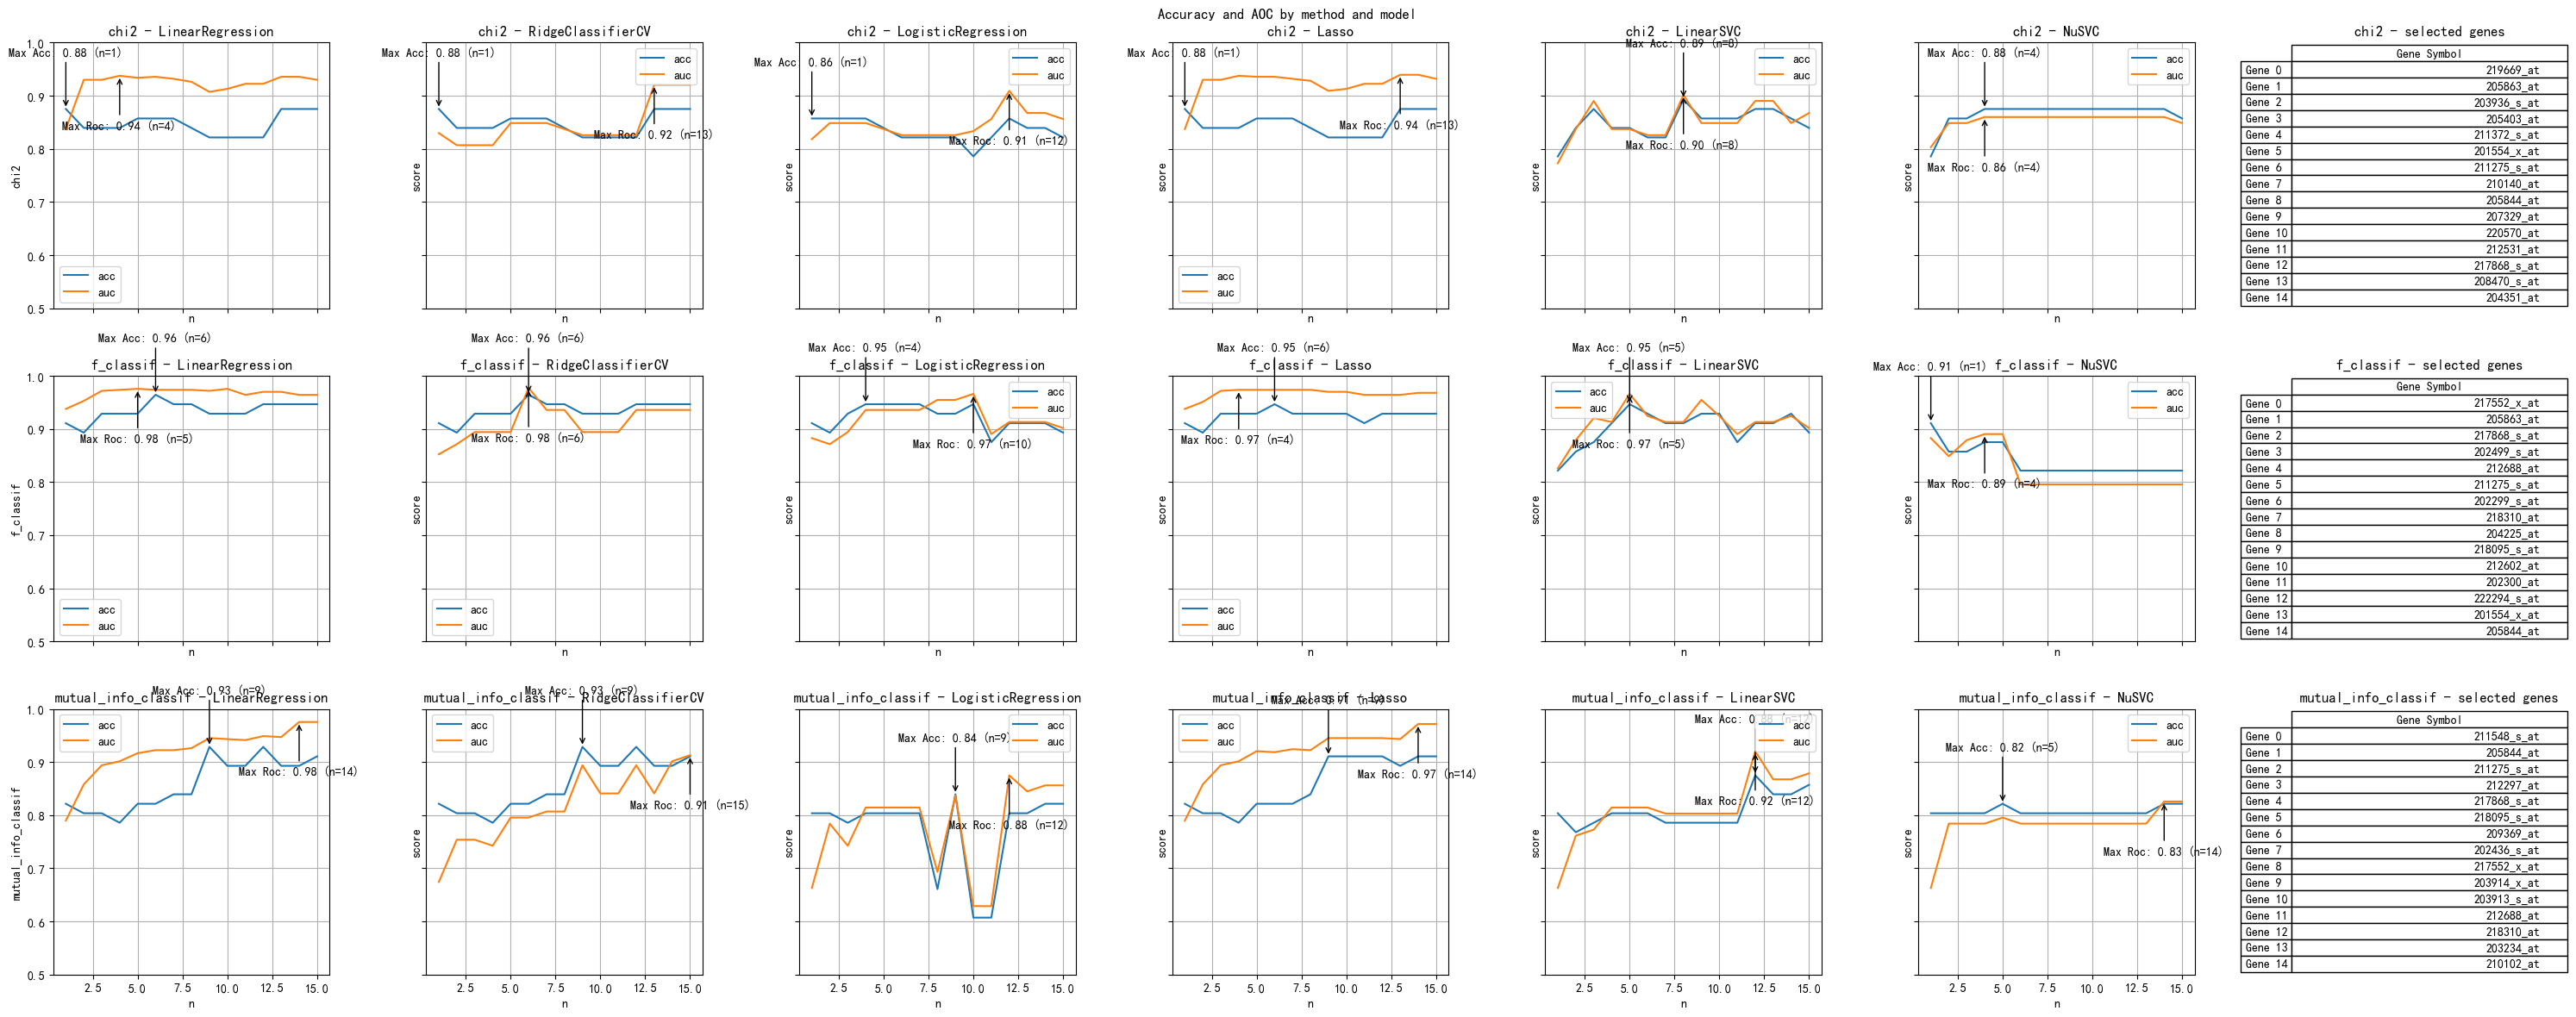

In [158]:
if not Skip_Paint:
    plot_all_results(results, methods, models, gpl)

获取上面训练的结果 —— 筛选出上面的表中表现的较好的方法

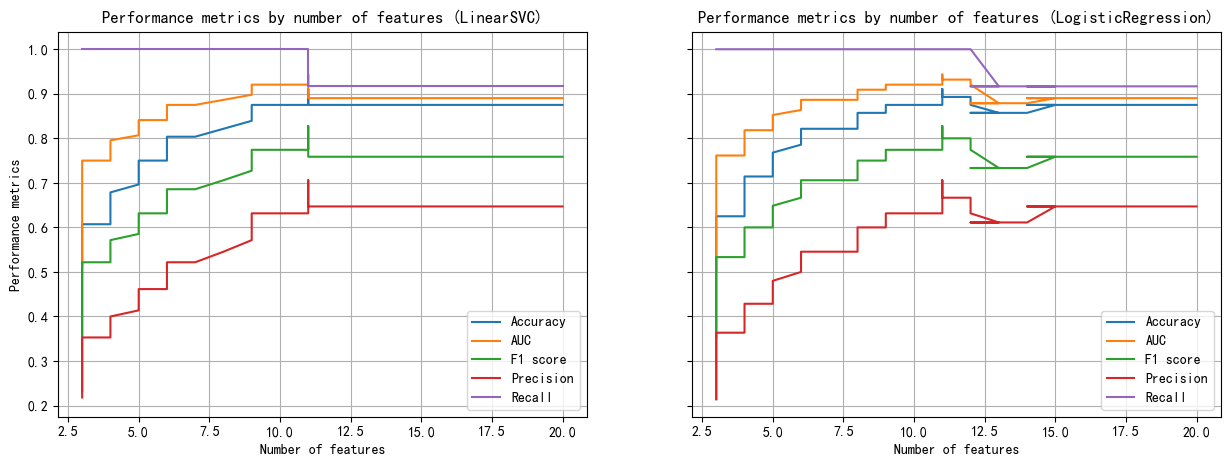

In [149]:
def evaluate_classifier(clf, X_train, y_train, X_test, y_test, params):
    acc_scores, auc_scores, f1_scores, precision_scores, recall_scores = [], [], [], [], []
    n_features = []

    for param in params:
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        n_features.append(np.sum(clf.coef_ != 0))
        y_pred = clf.predict(X_test)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred], dtype=int)
        acc_scores.append(clf.score(X_test, y_test))
        auc_scores.append(roc_auc_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))

    valid_indices = [i for i, n in enumerate(n_features) if 3 <= n <= 20]

    valid_acc_scores = [acc_scores[i] for i in valid_indices]
    valid_auc_scores = [auc_scores[i] for i in valid_indices]
    valid_f1_scores = [f1_scores[i] for i in valid_indices]
    valid_precision_scores = [precision_scores[i] for i in valid_indices]
    valid_recall_scores = [recall_scores[i] for i in valid_indices]
    valid_params = [params[i] for i in valid_indices]
    valid_n_features = [n_features[i] for i in valid_indices]

    return valid_acc_scores, valid_auc_scores, valid_f1_scores, valid_precision_scores, valid_recall_scores, valid_params, valid_n_features


C_values = np.logspace(-7, -3, num=300, base=10)

lsvc = LinearSVC(penalty="l1", dual=False)
lsvc_params = [{'C': C} for C in C_values]
lsvc_acc_scores, lsvc_auc_scores, lsvc_f1_scores, lsvc_precision_scores, lsvc_recall_scores, lsvc_params, n_features_lsvc = evaluate_classifier(lsvc, X_train, y_train, X_test, y_test, lsvc_params)

lr = LogisticRegression(penalty='l1', solver='liblinear')
lr_params = [{'C': C} for C in C_values]
lr_acc_scores, lr_auc_scores, lr_f1_scores, lr_precision_scores, lr_recall_scores, lr_params, n_features_lr = evaluate_classifier(lr, X_train, y_train, X_test, y_test, lr_params)

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15,5))

ax1.plot(n_features_lsvc, lsvc_acc_scores, label='Accuracy')
ax1.plot(n_features_lsvc, lsvc_auc_scores, label='AUC')
ax1.plot(n_features_lsvc, lsvc_f1_scores, label='F1 score')
ax1.plot(n_features_lsvc, lsvc_precision_scores, label='Precision')
ax1.plot(n_features_lsvc, lsvc_recall_scores, label='Recall')

ax2.plot(n_features_lr, lr_acc_scores, label='Accuracy')
ax2.plot(n_features_lr, lr_auc_scores, label='AUC')
ax2.plot(n_features_lr, lr_f1_scores, label='F1 score')
ax2.plot(n_features_lr, lr_precision_scores, label='Precision')
ax2.plot(n_features_lr, lr_recall_scores, label='Recall')

ax1.set_xlabel('Number of features')
ax2.set_xlabel('Number of features')
ax1.set_ylabel('Performance metrics')
ax1.set_title('Performance metrics by number of features (LinearSVC)')

ax2.set_xlabel('Number of features')
ax1.set_ylabel('Performance metrics')
ax1.set_title('Performance metrics by number of features (LinearSVC)')
ax2.set_title('Performance metrics by number of features (LogisticRegression)')
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()
plt.show()

In [66]:
sort_columns = ['found_coef','auc', 'f1', 'n']
sort_order = [False,False, False, True]

# Sort the DataFrame
results_sorted = results.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(20).copy().drop(['coef','found_coef','gene_id','intercept','multiple_times'], axis=1)
results_sorted_view

# todo: 当连续几个的gb_acc和coef_rounded都和上一个一样时，不用再显示出来。

,method,model,n,acc,auc,f1,precision,recall,confusionmatrix,coef_rounded,gene_symbol,gb_acc
0,f_classif,LinearRegression,5,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 24, 3, -8, -1]","[S100A12, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AI432713, BC000195, BC003393, NM_0..."
1,f_classif,LinearRegression,10,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, -4, -1, 1, 25, 4, -2, -8, -1, 12]","[S100A12, TMEM165, GYG1, KCTD7 /// RABGEF1, CR...","[NM_005621, BC003545, AF087942, NM_014504, AI4..."
2,f_classif,LinearRegression,4,0.928571,0.973485,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 20, 3, -1]","[S100A12, CR1, METTL9, SLC2A3]","[NM_005621, AI432713, BC000195, NM_006931]"
3,f_classif,Lasso,4,0.928571,0.973485,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 20, 3, -1]","[S100A12, CR1, METTL9, SLC2A3]","[NM_005621, AI432713, BC000195, NM_006931]"
4,f_classif,LinearRegression,8,0.946429,0.973485,0.880000,0.846154,0.916667,"[[42, 2], [1, 11]]","[1, -1, 1, 25, 4, -2, -6, -1]","[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
5,f_classif,LinearRegression,3,0.928571,0.971591,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 25, 4]","[S100A12, CR1, METTL9]","[NM_005621, AI432713, BC000195]"
6,f_classif,Lasso,3,0.928571,0.971591,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 24, 4]","[S100A12, CR1, METTL9]","[NM_005621, AI432713, BC000195]"
7,f_classif,LinearSVC,5,0.946429,0.965909,0.888889,0.800000,1.000000,"[[41, 3], [0, 12]]","[1, 24, 1, -15, -4]","[S100A12, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AI432713, BC000195, BC003393, NM_0..."
8,f_classif,LogisticRegression,8,0.928571,0.954545,0.857143,0.750000,1.000000,"[[40, 4], [0, 12]]","[1, 2, 18, 24, 2, -8, -24, -6]","[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
9,f_classif,LogisticRegression,9,0.928571,0.954545,0.857143,0.750000,1.000000,"[[40, 4], [0, 12]]","[1, 1, 9, 15, 1, -4, -10, -3, -4]","[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."


In [67]:
# select found_coef = True
results_sorted_found_coef = results_sorted[results_sorted['found_coef'] == True].reset_index(drop=True).copy()
reperduce = []
for i in range(len(results_sorted_found_coef)):
    gene_ids = results_sorted_found_coef['gene_id'][i].tolist()
    # check if gene_ids are in X_test columns
    if set(gene_ids).issubset(set(X_test.columns)):
        X_test_selected = X_test[gene_ids].copy()
    else:
        # modify gene_ids to match X_test columns
        gene_ids = [col for col in gene_ids if col in X_test.columns]
        X_test_selected = X_test[gene_ids].copy()
    y_test_selected = y_test
    # calculate score
    coef = results_sorted_found_coef['coef_rounded'][i]
    times = results_sorted_found_coef['multiple_times'][i]
    intercept = results_sorted_found_coef['intercept'][i]
    model_name = results_sorted_found_coef['model'][i]

    scores = []
    predictions = []
    
    # determine model and calculate scores and predictions
    if model_name == 'LinearRegression':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'RidgeClassifier' or model_name == 'RidgeClassifierCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
        for j in range(len(X_test_selected)):
            z = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            score = 1 / (1 + np.exp(-z))
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'Lasso' or model_name == 'LassoCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'ElasticNet':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'SGDClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    else:
        # handle SVC
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
        
    # calculate evaluation metrics
    acc = accuracy_score(y_test_selected, predictions)
    auc = roc_auc_score(y_test_selected, scores)
    f1 = f1_score(y_test_selected, predictions)
    precision = precision_score(y_test_selected, predictions)
    recall = recall_score(y_test_selected, predictions)

    # 能复现
    can_reproduce = True

    # if not acc == results_sorted_found_coef['acc'][i]:
    #     can_reproduce = False
    #     # print results
    #     print('Model:', model_name, 'n:', results_sorted_found_coef['n'][i],'acc:', acc, 'auc:', auc, 'f1:', f1, 'precision:', precision, 'recall:', recall)
    #     print(acc)
    #     print(results_sorted_found_coef['acc'][i])
    
    reperduce.append(can_reproduce)

results_sorted_found_coef['reproduce'] = reperduce
results_sorted_found_coef
    

,method,model,n,acc,auc,f1,precision,recall,confusionmatrix,coef,coef_rounded,found_coef,multiple_times,intercept,gene_id,gene_symbol,gb_acc,reproduce
0,f_classif,LinearRegression,5,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1.8795998131908714e-05, 0.0004756854826890543...","[1, 24, 3, -8, -1]",True,49885.616651,-0.0781975,"[205863_at, 217552_x_at, 217868_s_at, 212688_a...","[S100A12, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AI432713, BC000195, BC003393, NM_0...",True
1,f_classif,LinearRegression,10,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[2.3209433989538955e-05, -7.276327738908925e-0...","[1, -4, -1, 1, 25, 4, -2, -8, -1, 12]",True,56169.312725,-0.125887,"[205863_at, 218095_s_at, 211275_s_at, 218310_a...","[S100A12, TMEM165, GYG1, KCTD7 /// RABGEF1, CR...","[NM_005621, BC003545, AF087942, NM_014504, AI4...",True
2,f_classif,LinearRegression,4,0.928571,0.973485,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1.822220283787834e-05, 0.0004531333771844806,...","[1, 20, 3, -1]",True,44752.929843,-0.0856369,"[205863_at, 217552_x_at, 217868_s_at, 202499_s...","[S100A12, CR1, METTL9, SLC2A3]","[NM_005621, AI432713, BC000195, NM_006931]",True
3,f_classif,Lasso,4,0.928571,0.973485,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1.810959905415868e-05, 0.0004301321347911568,...","[1, 20, 3, -1]",True,47154.544528,-0.0878236,"[205863_at, 217552_x_at, 217868_s_at, 202499_s...","[S100A12, CR1, METTL9, SLC2A3]","[NM_005621, AI432713, BC000195, NM_006931]",True
4,f_classif,LinearRegression,8,0.946429,0.973485,0.880000,0.846154,0.916667,"[[42, 2], [1, 11]]","[2.186166703767949e-05, -1.3138535187999978e-0...","[1, -1, 1, 25, 4, -2, -6, -1]",True,53219.812129,-0.0909722,"[205863_at, 211275_s_at, 218310_at, 217552_x_a...","[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0...",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,mutual_info_classif,RidgeClassifier,4,0.785714,0.742424,0.571429,0.500000,0.666667,"[[36, 8], [4, 8]]","[[-0.0007130123485090148, 0.000159527899906746...","[-12, 3, 25, 2]",True,16936.005128,[-0.9206822046191265],"[211548_s_at, 205844_at, 212297_at, 211275_s_at]","[HPGD, VNN1, ATP13A3, GYG1]","[J05594, NM_004666, BF218804, AF087942]",True
156,mutual_info_classif,RidgeClassifier,1,0.821429,0.674242,0.500000,0.625000,0.416667,"[[41, 3], [7, 5]]",[[0.001167573747408013]],[25],True,21411.923705,[-0.24278154343826455],[211548_s_at],[HPGD],[J05594],True
157,mutual_info_classif,LogisticRegression,1,0.803571,0.662879,0.476190,0.555556,0.416667,"[[40, 4], [7, 5]]",[[0.008095838817604449]],[25],True,3088.006143,[-1.02205091627991],[211548_s_at],[HPGD],[J05594],True
158,mutual_info_classif,LinearSVC,1,0.803571,0.662879,0.476190,0.555556,0.416667,"[[40, 4], [7, 5]]",[[0.002059722685925054]],[25],True,12137.556270,[-0.1996585000683749],[211548_s_at],[HPGD],[J05594],True


In [70]:
sort_columns = ['found_coef','reproduce','f1', 'auc', 'recall']
sort_order = [False,False, False,False, False]

# Sort the DataFrame
results_sorted = results_sorted_found_coef.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(20).copy().drop(['coef','found_coef','gene_id','reproduce'], axis=1)

vir_sorted = results_sorted_view.copy()
vir_sorted
# todo: 当连续几个的gb_acc和coef_rounded都和上一个一样时，不用再显示出来。

,method,model,n,acc,auc,f1,precision,recall,confusionmatrix,coef_rounded,multiple_times,intercept,gene_symbol,gb_acc
0,f_classif,LinearSVC,5,0.946429,0.965909,0.888889,0.800000,1.000000,"[[41, 3], [0, 12]]","[1, 24, 1, -15, -4]",14634.693704,[-0.44892749593742853],"[S100A12, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AI432713, BC000195, BC003393, NM_0..."
1,f_classif,LinearRegression,8,0.946429,0.973485,0.880000,0.846154,0.916667,"[[42, 2], [1, 11]]","[1, -1, 1, 25, 4, -2, -6, -1]",53219.812129,-0.0909722,"[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
2,f_classif,RidgeClassifier,8,0.946429,0.935606,0.880000,0.846154,0.916667,"[[42, 2], [1, 11]]","[1, -1, 1, 25, 4, -2, -6, -1]",26609.910375,[-1.1819444120420752],"[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
3,f_classif,LogisticRegression,8,0.928571,0.954545,0.857143,0.750000,1.000000,"[[40, 4], [0, 12]]","[1, 2, 18, 24, 2, -8, -24, -6]",4307.120883,[-0.013390131570581587],"[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
4,f_classif,LogisticRegression,9,0.928571,0.954545,0.857143,0.750000,1.000000,"[[40, 4], [0, 12]]","[1, 1, 9, 15, 1, -4, -10, -3, -4]",2417.688716,[-0.00016738916390759514],"[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
5,f_classif,LinearSVC,9,0.928571,0.954545,0.857143,0.750000,1.000000,"[[40, 4], [0, 12]]","[1, 2, 10, 20, 1, -6, -12, -4, -5]",9369.101511,[0.0],"[S100A12, GYG1, KCTD7 /// RABGEF1, CR1, METTL9...","[NM_005621, AF087942, NM_014504, AI432713, BC0..."
6,f_classif,LinearSVC,6,0.928571,0.924242,0.846154,0.785714,0.916667,"[[41, 3], [1, 11]]","[1, 2, 24, 1, -18, -5]",14388.673399,[-0.3049381390814171],"[S100A12, GYG1, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AF087942, AI432713, BC000195, BC00..."
7,f_classif,LinearRegression,5,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 24, 3, -8, -1]",49885.616651,-0.0781975,"[S100A12, CR1, METTL9, PIK3CB, SLC2A3]","[NM_005621, AI432713, BC000195, BC003393, NM_0..."
8,f_classif,LinearRegression,10,0.928571,0.975379,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, -4, -1, 1, 25, 4, -2, -8, -1, 12]",56169.312725,-0.125887,"[S100A12, TMEM165, GYG1, KCTD7 /// RABGEF1, CR...","[NM_005621, BC003545, AF087942, NM_014504, AI4..."
9,f_classif,LinearRegression,4,0.928571,0.973485,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]","[1, 20, 3, -1]",44752.929843,-0.0856369,"[S100A12, CR1, METTL9, SLC2A3]","[NM_005621, AI432713, BC000195, NM_006931]"


## 细菌

In [59]:
# 病毒与未感染的鉴别
bacterial_data = gse_csv[gse_csv['infection_status'].isin(['viral', 'non-infectious illness','bacterial'])]
bacterial_data['target'] = bacterial_data['infection_status'].map({'bacterial': 1, 'viral': 0, 'non-infectious illness':0})
X_train, X_test, y_train, y_test = train_test_split(bacterial_data.drop(['infection_status'], axis=1), bacterial_data['infection_status'], test_size=0.2, random_state=0)
bacterial_data['infection_status'].value_counts()

viral                     117
non-infectious illness     90
bacterial                  73
Name: infection_status, dtype: int64

In [60]:
higher_columns, higher_times = get_higher_columns(bacterial_data)

In [61]:
data_higher, data_higher_times = sort_higher_columns(bacterial_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'], test_size=0.2, random_state=0)
X_train, y_train = sm.fit_resample(data_higher.drop(['infection_status','target'], axis=1), data_higher['target'])

In [62]:
if not Skip_Paint:
    plot_boxplot(data_higher, gpl, gse_csv, data_higher_times)

选

In [63]:
results = test_all(methods=methods, models=models, n_features=n_features, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, gpl=gpl)
if not Skip_Paint:
    plot_all_results(results, methods, models, gpl)

KeyboardInterrupt: 

In [ ]:
sort_columns = ['found_coef','auc', 'f1', 'n']
sort_order = [False,False, False, True]

# Sort the DataFrame
results_sorted = results.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(20).copy().drop(['coef','found_coef','gene_id','intercept','multiple_times'], axis=1)
results_sorted_view

# todo: 当连续几个的gb_acc和coef_rounded都和上一个一样时，不用再显示出来。

,method,model,n,acc,auc,f1,precision,recall,confusionmatrix,coef_rounded,gene_symbol,gb_acc
0,f_classif,LinearRegression,2,0.910714,0.952652,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]","[1, 18]","[S100A12, CR1]","[NM_005621, AI432713]"
1,f_classif,Lasso,2,0.910714,0.952652,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]","[1, 16]","[S100A12, CR1]","[NM_005621, AI432713]"
2,mutual_info_classif,LinearRegression,4,0.875000,0.946970,0.720000,0.692308,0.750000,"[[40, 4], [3, 9]]","[1, 10, 18, 5]","[VNN1, ATP13A3, CR1, LAMTOR5]","[NM_004666, BF218804, AI432713, NM_006402]"
3,mutual_info_classif,Lasso,4,0.875000,0.945076,0.720000,0.692308,0.750000,"[[40, 4], [3, 9]]","[1, 12, 25, 8]","[VNN1, ATP13A3, CR1, LAMTOR5]","[NM_004666, BF218804, AI432713, NM_006402]"
4,f_classif,LinearRegression,1,0.910714,0.937500,0.782609,0.818182,0.750000,"[[42, 2], [3, 9]]",[25],[CR1],[AI432713]
5,f_classif,Lasso,1,0.910714,0.937500,0.782609,0.818182,0.750000,"[[42, 2], [3, 9]]",[25],[CR1],[AI432713]
6,chi2,LinearRegression,4,0.839286,0.937500,0.666667,0.600000,0.750000,"[[38, 6], [3, 9]]","[8, 6, 16, 1]","[CD177, IL1R2, S100A12, MMP9]","[NM_020406, NM_004633, NM_005621, NM_004994]"
7,chi2,Lasso,4,0.839286,0.937500,0.666667,0.600000,0.750000,"[[38, 6], [3, 9]]","[8, 6, 16, 1]","[CD177, IL1R2, S100A12, MMP9]","[NM_020406, NM_004633, NM_005621, NM_004994]"
8,chi2,LinearRegression,2,0.857143,0.928030,0.714286,0.625000,0.833333,"[[38, 6], [2, 10]]","[8, 15]","[CD177, S100A12]","[NM_020406, NM_005621]"
9,chi2,Lasso,2,0.857143,0.928030,0.714286,0.625000,0.833333,"[[38, 6], [2, 10]]","[8, 15]","[CD177, S100A12]","[NM_020406, NM_005621]"


In [ ]:
# select found_coef = True
results_sorted_found_coef = results_sorted[results_sorted['found_coef'] == True].reset_index(drop=True).copy()
reperduce = []
for i in range(len(results_sorted_found_coef)):
    gene_ids = results_sorted_found_coef['gene_id'][i].tolist()
    # check if gene_ids are in X_test columns
    if set(gene_ids).issubset(set(X_test.columns)):
        X_test_selected = X_test[gene_ids].copy()
    else:
        # modify gene_ids to match X_test columns
        gene_ids = [col for col in gene_ids if col in X_test.columns]
        X_test_selected = X_test[gene_ids].copy()
    y_test_selected = y_test
    # calculate score
    coef = results_sorted_found_coef['coef_rounded'][i]
    times = results_sorted_found_coef['multiple_times'][i]
    intercept = results_sorted_found_coef['intercept'][i]
    model_name = results_sorted_found_coef['model'][i]

    scores = []
    predictions = []
    
    # determine model and calculate scores and predictions
    if model_name == 'LinearRegression':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'RidgeClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
        for j in range(len(X_test_selected)):
            z = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            score = 1 / (1 + np.exp(-z))
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'Lasso' or model_name == 'LassoCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'ElasticNet':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[[j]], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'SGDClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    else:
        # handle SVC
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
        
    # calculate evaluation metrics
    acc = accuracy_score(y_test_selected, predictions)
    auc = roc_auc_score(y_test_selected, scores)
    f1 = f1_score(y_test_selected, predictions)
    precision = precision_score(y_test_selected, predictions)
    recall = recall_score(y_test_selected, predictions)

    # 能复现
    can_reproduce = True

    # if not acc == results_sorted_found_coef['acc'][i]:
    #     can_reproduce = False
    #     # print results
    #     print('Model:', model_name, 'n:', results_sorted_found_coef['n'][i],'acc:', acc, 'auc:', auc, 'f1:', f1, 'precision:', precision, 'recall:', recall)
    #     print(acc)
    #     print(results_sorted_found_coef['acc'][i])
    
    reperduce.append(can_reproduce)

results_sorted_found_coef['reproduce'] = reperduce

In [ ]:
# recall is more important, so calculate another score just like f1
results_sorted_found_coef['recall_score'] = results_sorted_found_coef['recall'] * results_sorted_found_coef['auc']

In [ ]:
sort_columns = ['found_coef','reproduce','f1', 'auc', 'n']
sort_order = [False,False, False,False, True]

# Sort the DataFrame
results_sorted = results_sorted_found_coef.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(20).copy().drop(['coef','found_coef','gene_id','reproduce'], axis=1)

bac_sorted = results_sorted_view.copy()
bac_sorted
# todo: 当连续几个的gb_acc和coef_rounded都和上一个一样时，不用再显示出来。

,method,model,n,acc,auc,f1,precision,recall,confusionmatrix,coef_rounded,multiple_times,intercept,gene_symbol,gb_acc,recall_score
0,f_classif,NuSVC,1,0.928571,0.893939,0.833333,0.833333,0.833333,"[[42, 2], [2, 10]]",[25],7601.901587,[-2.0062397164525736],[CR1],[AI432713],0.744949
1,f_classif,LinearRegression,2,0.910714,0.952652,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]","[1, 18]",38273.895415,-0.0256341,"[S100A12, CR1]","[NM_005621, AI432713]",0.793876
2,f_classif,Lasso,2,0.910714,0.952652,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]","[1, 16]",34834.697576,-0.0228764,"[S100A12, CR1]","[NM_005621, AI432713]",0.793876
3,f_classif,LogisticRegression,1,0.910714,0.882576,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]",[25],4306.622633,[-3.508325149458375],[CR1],[AI432713],0.735480
4,f_classif,RidgeClassifier,2,0.910714,0.882576,0.800000,0.769231,0.833333,"[[41, 3], [2, 10]]","[1, 18]",19136.948090,[-1.0512681726460524],"[S100A12, CR1]","[NM_005621, AI432713]",0.735480
5,f_classif,LinearRegression,1,0.910714,0.937500,0.782609,0.818182,0.750000,"[[42, 2], [3, 9]]",[25],33994.338994,0.010356,[CR1],[AI432713],0.703125
6,f_classif,Lasso,1,0.910714,0.937500,0.782609,0.818182,0.750000,"[[42, 2], [3, 9]]",[25],34223.662500,0.013637,[CR1],[AI432713],0.703125
7,f_classif,RidgeClassifier,1,0.910714,0.852273,0.782609,0.818182,0.750000,"[[42, 2], [3, 9]]",[25],16997.169700,[-0.979287941859612],[CR1],[AI432713],0.639205
8,f_classif,LogisticRegression,2,0.892857,0.871212,0.769231,0.714286,0.833333,"[[40, 4], [2, 10]]","[1, 25]",6224.602810,[-3.4246920473926545],"[S100A12, CR1]","[NM_005621, AI432713]",0.726010
9,chi2,NuSVC,4,0.875000,0.859848,0.740741,0.666667,0.833333,"[[39, 5], [2, 10]]","[15, 8, 16, 6]",216135.000222,[-1.3741396276872013],"[CD177, IL1R2, S100A12, MMP9]","[NM_020406, NM_004633, NM_005621, NM_004994]",0.716540


# 测试

### 我们的模型

In [ ]:
# 选择的模型
# 病毒高的
up_sorted_best = vir_sorted.iloc[0].copy()
up_feature =  up_sorted_best.gene_symbol
up_weight = up_sorted_best.coef_rounded
up_times = up_sorted_best.multiple_times
up_intercept = up_sorted_best.intercept
up_model = up_sorted_best.model
# 细菌高的
down_sorted_best = bac_sorted.iloc[0].copy()
down_feature =  down_sorted_best.gene_symbol
down_weight = down_sorted_best.coef_rounded
down_times = down_sorted_best.multiple_times
down_intercept = down_sorted_best.intercept
down_model = down_sorted_best.model
# 实际输入的模型
feature =  up_feature + down_feature
print('feature:', feature)
weight = up_weight + (np.array(down_weight) * -1).tolist()
print('weight:', weight)

feature: ['S100A12', 'MMP9', 'CR1']
weight: [25, 18, -25]


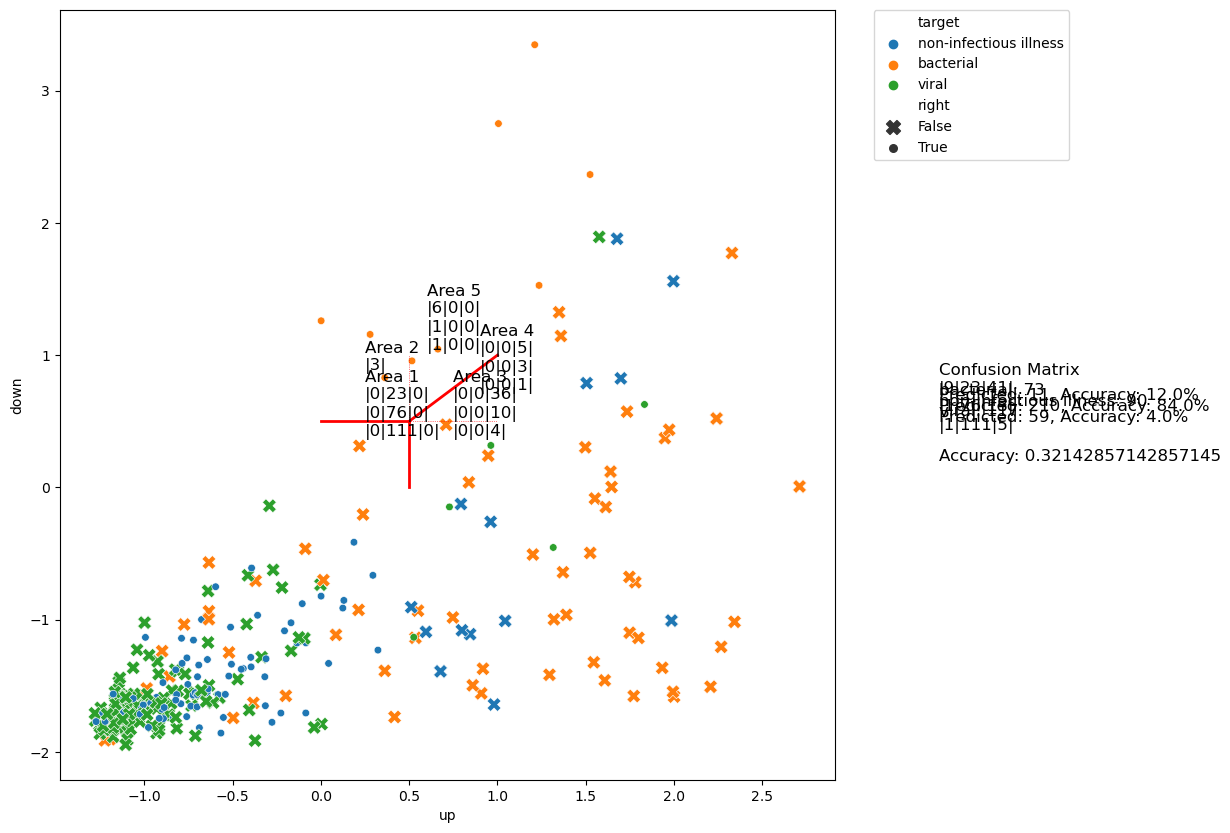

In [ ]:
up_score = cal_score_with_feature(gse_csv, gpl, up_feature, up_weight, up_times, up_intercept, model=up_model)
down_score = cal_score_with_feature(gse_csv, gpl, down_feature, down_weight, down_times, down_intercept, model=down_model)
target = gse_csv['infection_status']
merge = pd.concat([up_score, down_score, target], axis=1)
merge.columns = ['up', 'down', 'target']
merge_by_target = merge.groupby('target')
# the dict of the target and how many times it appears
target_dict = dict(merge_by_target.size())

# where the target should be
# non-infectious illness：up和down都小于0.5
# bacterial：down大于0.5，且up<down
# viral：up大于0.5，且up>down
conditions = [
    (merge['up'] < 0.5) & (merge['down'] < 0.5),
    (merge['up'] < 0.5) & (merge['down'] > 0.5),
    (merge['up'] > 0.5) & (merge['down'] < 0.5),
    (merge['up'] > 0.5) & (merge['down'] > 0.5) & (merge['up'] > merge['down']),
    (merge['up'] > 0.5) & (merge['down'] > 0.5) & (merge['up'] < merge['down'])
]
place_for_text = [
    (0.25, 0.25),
    (0.25, 0.75),
    (0.75, 0.25),
    # (0.75, 0.75), should be righter and lower
    (0.9, 0.6),
    (0.6, 0.9)
]
target_map = [
    'non-infectious illness',
    'bacterial',
    'viral',
    'viral',
    'bacterial'
]
merge['predict'] = np.select(conditions, target_map)
merge['right'] = merge['target'] == merge['predict']
merge['area'] = np.select(conditions, ['1', '2', '3', '4', '5'])

# accuracy
accuracy_score(merge['target'], merge['predict'])

# plot
plt.figure(figsize=(10, 10))
# sns.scatterplot(data=merge, x='up', y='down', hue='target', style='right', s=100) # style='right' will make those True points drawn as x. Should fix it.
sns.scatterplot(data=merge, x='up', y='down', hue='target', style='right',style_order=[True,False], s=30, size='right', sizes=[100, 30])
plt.plot([0.5, 1], [0.5, 1], color='red', linewidth=2)
# x=0.5, y 0~0.5
plt.plot([0.5, 0.5], [0, 0.5], color='red', linewidth=2)
# x=0.5~1, y=0.5
plt.plot([0, 0.5], [0.5, 0.5], color='red', linewidth=2)
# x=0.5~1, y=0.5~1, width=0.5, 
plt.plot([0.5, 1], [0.5, 0.5], color='red', linewidth=0.5, linestyle='dotted')
plt.plot([0.5, 0.5], [0.5, 1], color='red', linewidth=0.5, linestyle='dotted')

# plot the area
merge_by_area = merge.groupby('area')
for area in ['1', '2', '3', '4', '5']:
    try:
        area_data = merge_by_area.get_group(area)
        area_data_confusion_matrix = confusion_matrix(area_data['target'], area_data['predict'])
        text = f'Area {area}\n'
        for i in range(len(area_data_confusion_matrix)):
            for j in range(len(area_data_confusion_matrix)):
                text += f'|{area_data_confusion_matrix[i][j]}'
            text += '|\n'
        plt.text(place_for_text[int(area)-1][0], place_for_text[int(area)-1][1], text, fontsize=12)
    except:
        # plt.text(place_for_text[int(area)-1][0], place_for_text[int(area)-1][1], f'Area {area}\n0\n0\n0', fontsize=12)
        pass

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# 在右边显示各个target的数量
for i in range(len(target_dict)):
    plt.text(3.5, 0.7 - 0.08 * i, f'{list(target_dict.keys())[i]}: {list(target_dict.values())[i]}', fontsize=12)
    # 实际被预测为该target的数量
    # plt.text(1.11, 1.01 - 0.08 * i, f'Predicted: {len(merge[merge["predict"] == list(target_dict.keys())[i]])}, Accuracy: {accuracy_score(merge[merge["target"] == list(target_dict.keys())[i]]["target"], merge[merge["target"] == list(target_dict.keys())[i]]["predict"])}', fontsize=12)
    # acc only keep 2 digits and use %
    plt.text(3.5, 0.66 - 0.08 * i, f'Predicted: {len(merge[merge["predict"] == list(target_dict.keys())[i]])}, Accuracy: {round(accuracy_score(merge[merge["target"] == list(target_dict.keys())[i]]["target"], merge[merge["target"] == list(target_dict.keys())[i]]["predict"]), 2) * 100}%', fontsize=12)
# confusion matrix , also plot the text
confusion_matrix_text = confusion_matrix(merge['target'], merge['predict'])
text = 'Confusion Matrix\n'
for i in range(len(confusion_matrix_text)):
    for j in range(len(confusion_matrix_text)):
        text += f'|{confusion_matrix_text[i][j]}'
    text += '|'
    text += '\n'
plt.text(3.5, 0.3, text, fontsize=12)

# accuracy
plt.text(3.5, 0.2, f'Accuracy: {accuracy_score(merge["target"], merge["predict"])}', fontsize=12)

plt.show()

(<Figure size 1200x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'分数分布图'}, xlabel='样本序号', ylabel='分数'>,
         <AxesSubplot:title={'center':'ROC 曲线（受试者工作特征曲线）'}, xlabel='False Positive Rate 假阳性率', ylabel='True Positive Rate 真阳性率'>],
        [<AxesSubplot:title={'center':'PR 曲线（准确率-召回率曲线）'}, xlabel='Recall 召回率', ylabel='Precision 准确率'>,
         <AxesSubplot:title={'center':'Confusion Matrix 混淆矩阵'}, xlabel='Predicted label 预测情况', ylabel='True label 感染情况'>]],
       dtype=object))

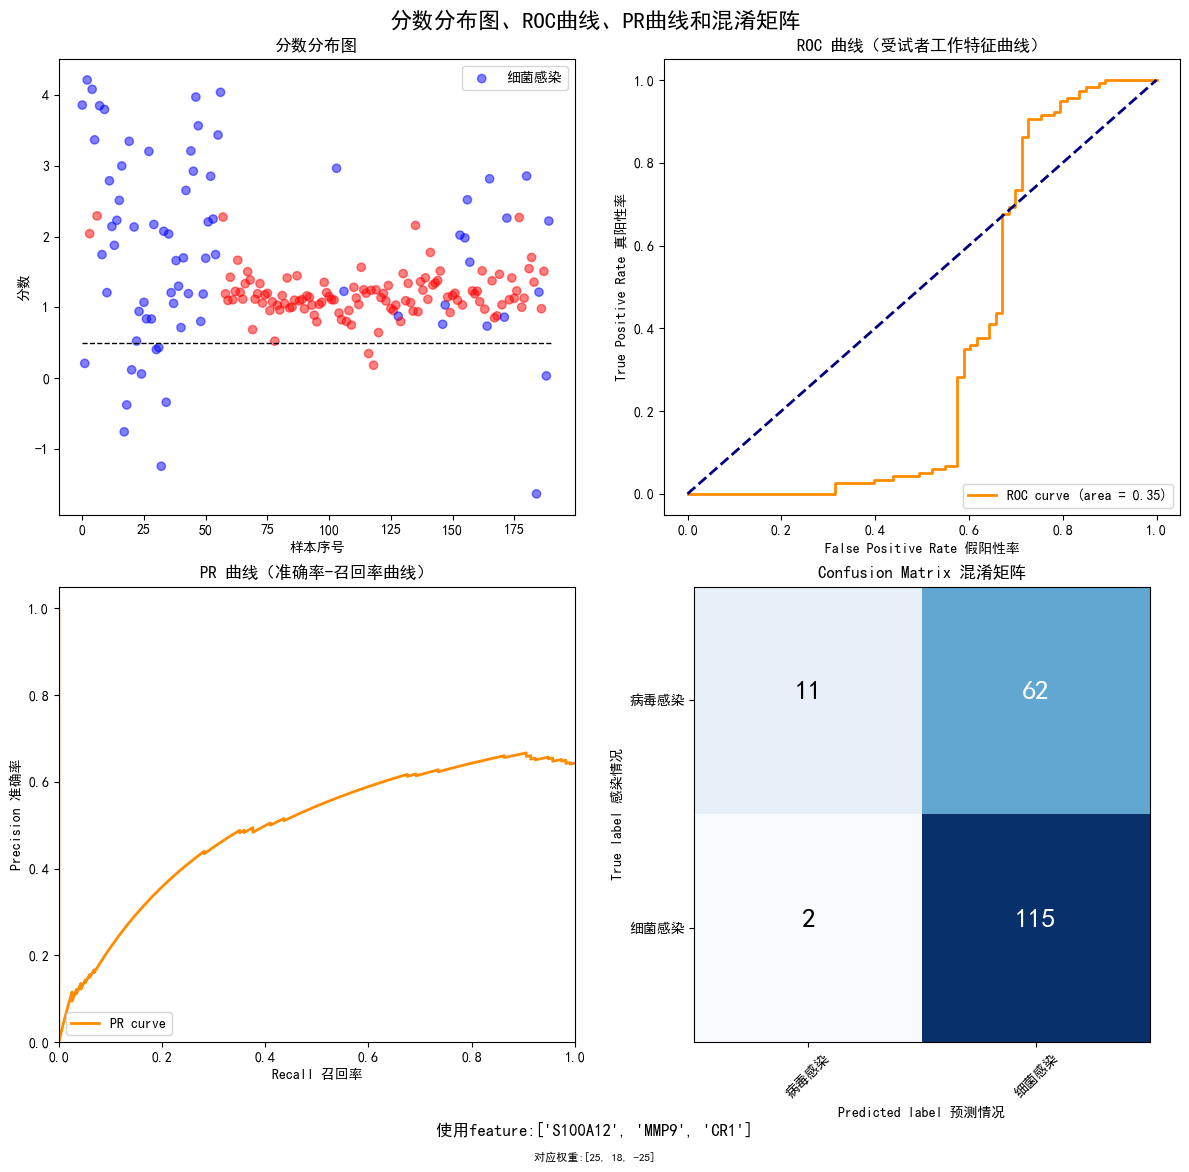

In [ ]:
test_data = gse_csv[gse_csv['infection_status'].isin(['viral', 'bacterial'])]
test_data['target'] = test_data['infection_status'].map({'viral': 1, 'bacterial': 0})

merge_2 = merge[merge['target'] != 'non-infectious illness'].copy()

viral_score = merge_2['up']
bacterial_score = merge_2['down']
target = merge_2['target'].map({'viral': 1, 'bacterial': 0})

# score is  viral_score - bacterial_score + 0.5
# viral_score,  bacterial_score and score are list.
score = np.array(viral_score) - np.array(bacterial_score) + 0.5

plot_all(
    score, 
    target,
    title="分数分布图、ROC曲线、PR曲线和混淆矩阵",
    feature=feature,
    weight=weight
)

### 文献的模型

In [ ]:
# 文献中模型
# 病毒高的
up_sorted_best = vir_sorted.iloc[0].copy()
up_feature =  ['IFIT1', 'TRDV3', 'SIGLEC1','LY6E']
up_weight = [1,1 ,4, 4]
up_times = 19000
up_intercept = -0.5
up_model = 'LogisticRegression'
# 细菌高的
down_sorted_best = bac_sorted.iloc[0].copy()
down_feature = ['ARG1', 'CD177', 'VNN1']
down_weight = [1, 4, 5]
down_times = 30000
down_intercept = -0.5
down_model = 'LogisticRegression'
# 实际输入的模型
feature =  up_feature + down_feature
print('feature:', feature)
weight = up_weight + (np.array(down_weight) * -1).tolist()
print('weight:', weight)

feature: ['IFIT1', 'TRDV3', 'SIGLEC1', 'LY6E', 'ARG1', 'CD177', 'VNN1']
weight: [1, 1, 4, 4, -1, -4, -5]


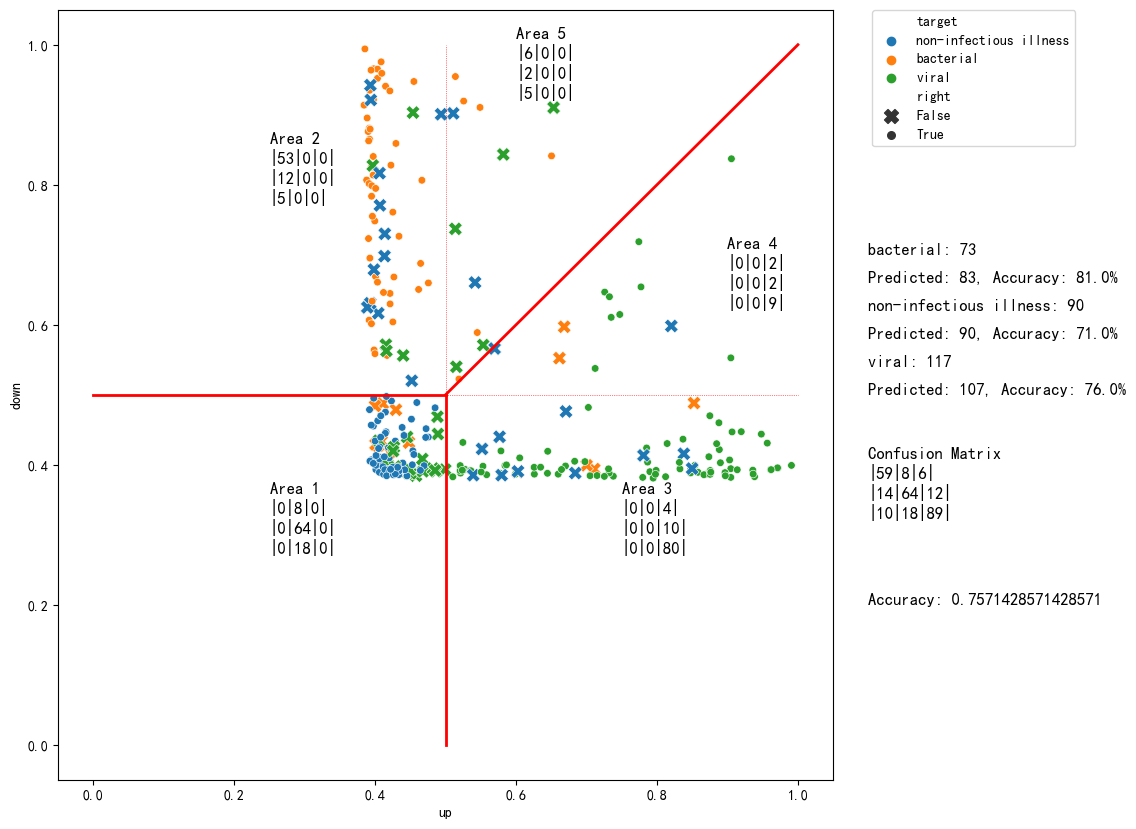

In [ ]:
up_score = cal_score_with_feature(gse_csv, gpl, up_feature, up_weight, up_times, up_intercept, model=up_model)
down_score = cal_score_with_feature(gse_csv, gpl, down_feature, down_weight, down_times, down_intercept, model=down_model)
target = gse_csv['infection_status']
merge = pd.concat([up_score, down_score, target], axis=1)
merge.columns = ['up', 'down', 'target']
merge_by_target = merge.groupby('target')
# the dict of the target and how many times it appears
target_dict = dict(merge_by_target.size())

# where the target should be
# non-infectious illness：up和down都小于0.5
# bacterial：down大于0.5，且up<down
# viral：up大于0.5，且up>down
conditions = [
    (merge['up'] < 0.5) & (merge['down'] < 0.5),
    (merge['up'] < 0.5) & (merge['down'] > 0.5),
    (merge['up'] > 0.5) & (merge['down'] < 0.5),
    (merge['up'] > 0.5) & (merge['down'] > 0.5) & (merge['up'] > merge['down']),
    (merge['up'] > 0.5) & (merge['down'] > 0.5) & (merge['up'] < merge['down'])
]
place_for_text = [
    (0.25, 0.25),
    (0.25, 0.75),
    (0.75, 0.25),
    # (0.75, 0.75), should be righter and lower
    (0.9, 0.6),
    (0.6, 0.9)
]
target_map = [
    'non-infectious illness',
    'bacterial',
    'viral',
    'viral',
    'bacterial'
]
merge['predict'] = np.select(conditions, target_map)
merge['right'] = merge['target'] == merge['predict']
merge['area'] = np.select(conditions, ['1', '2', '3', '4', '5'])

# accuracy
accuracy_score(merge['target'], merge['predict'])

# plot
plt.figure(figsize=(10, 10))
# sns.scatterplot(data=merge, x='up', y='down', hue='target', style='right', s=100) # style='right' will make those True points drawn as x. Should fix it.
sns.scatterplot(data=merge, x='up', y='down', hue='target', style='right',style_order=[True,False], s=30, size='right', sizes=[100, 30])
plt.plot([0.5, 1], [0.5, 1], color='red', linewidth=2)
# x=0.5, y 0~0.5
plt.plot([0.5, 0.5], [0, 0.5], color='red', linewidth=2)
# x=0.5~1, y=0.5
plt.plot([0, 0.5], [0.5, 0.5], color='red', linewidth=2)
# x=0.5~1, y=0.5~1, width=0.5, 
plt.plot([0.5, 1], [0.5, 0.5], color='red', linewidth=0.5, linestyle='dotted')
plt.plot([0.5, 0.5], [0.5, 1], color='red', linewidth=0.5, linestyle='dotted')

# plot the area
merge_by_area = merge.groupby('area')
for area in ['1', '2', '3', '4', '5']:
    try:
        area_data = merge_by_area.get_group(area)
        area_data_confusion_matrix = confusion_matrix(area_data['target'], area_data['predict'])
        text = f'Area {area}\n'
        for i in range(len(area_data_confusion_matrix)):
            for j in range(len(area_data_confusion_matrix)):
                text += f'|{area_data_confusion_matrix[i][j]}'
            text += '|\n'
        plt.text(place_for_text[int(area)-1][0], place_for_text[int(area)-1][1], text, fontsize=12)
    except:
        # plt.text(place_for_text[int(area)-1][0], place_for_text[int(area)-1][1], f'Area {area}\n0\n0\n0', fontsize=12)
        pass

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


# 在右边显示各个target的数量
for i in range(len(target_dict)):
    plt.text(1.1, 0.7 - 0.08 * i, f'{list(target_dict.keys())[i]}: {list(target_dict.values())[i]}', fontsize=12)
    # 实际被预测为该target的数量
    # plt.text(1.11, 1.01 - 0.08 * i, f'Predicted: {len(merge[merge["predict"] == list(target_dict.keys())[i]])}, Accuracy: {accuracy_score(merge[merge["target"] == list(target_dict.keys())[i]]["target"], merge[merge["target"] == list(target_dict.keys())[i]]["predict"])}', fontsize=12)
    # acc only keep 2 digits and use %
    plt.text(1.1, 0.66 - 0.08 * i, f'Predicted: {len(merge[merge["predict"] == list(target_dict.keys())[i]])}, Accuracy: {round(accuracy_score(merge[merge["target"] == list(target_dict.keys())[i]]["target"], merge[merge["target"] == list(target_dict.keys())[i]]["predict"]), 2) * 100}%', fontsize=12)
# confusion matrix , also plot the text
confusion_matrix_text = confusion_matrix(merge['target'], merge['predict'])
text = 'Confusion Matrix\n'
for i in range(len(confusion_matrix_text)):
    for j in range(len(confusion_matrix_text)):
        text += f'|{confusion_matrix_text[i][j]}'
    text += '|'
    text += '\n'
plt.text(1.1, 0.3, text, fontsize=12)

# accuracy
plt.text(1.1, 0.2, f'Accuracy: {accuracy_score(merge["target"], merge["predict"])}', fontsize=12)

plt.show()

(<Figure size 1200x1200 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'分数分布图'}, xlabel='样本序号', ylabel='分数'>,
         <AxesSubplot:title={'center':'ROC 曲线（受试者工作特征曲线）'}, xlabel='False Positive Rate 假阳性率', ylabel='True Positive Rate 真阳性率'>],
        [<AxesSubplot:title={'center':'PR 曲线（准确率-召回率曲线）'}, xlabel='Recall 召回率', ylabel='Precision 准确率'>,
         <AxesSubplot:title={'center':'Confusion Matrix 混淆矩阵'}, xlabel='Predicted label 预测情况', ylabel='True label 感染情况'>]],
       dtype=object))

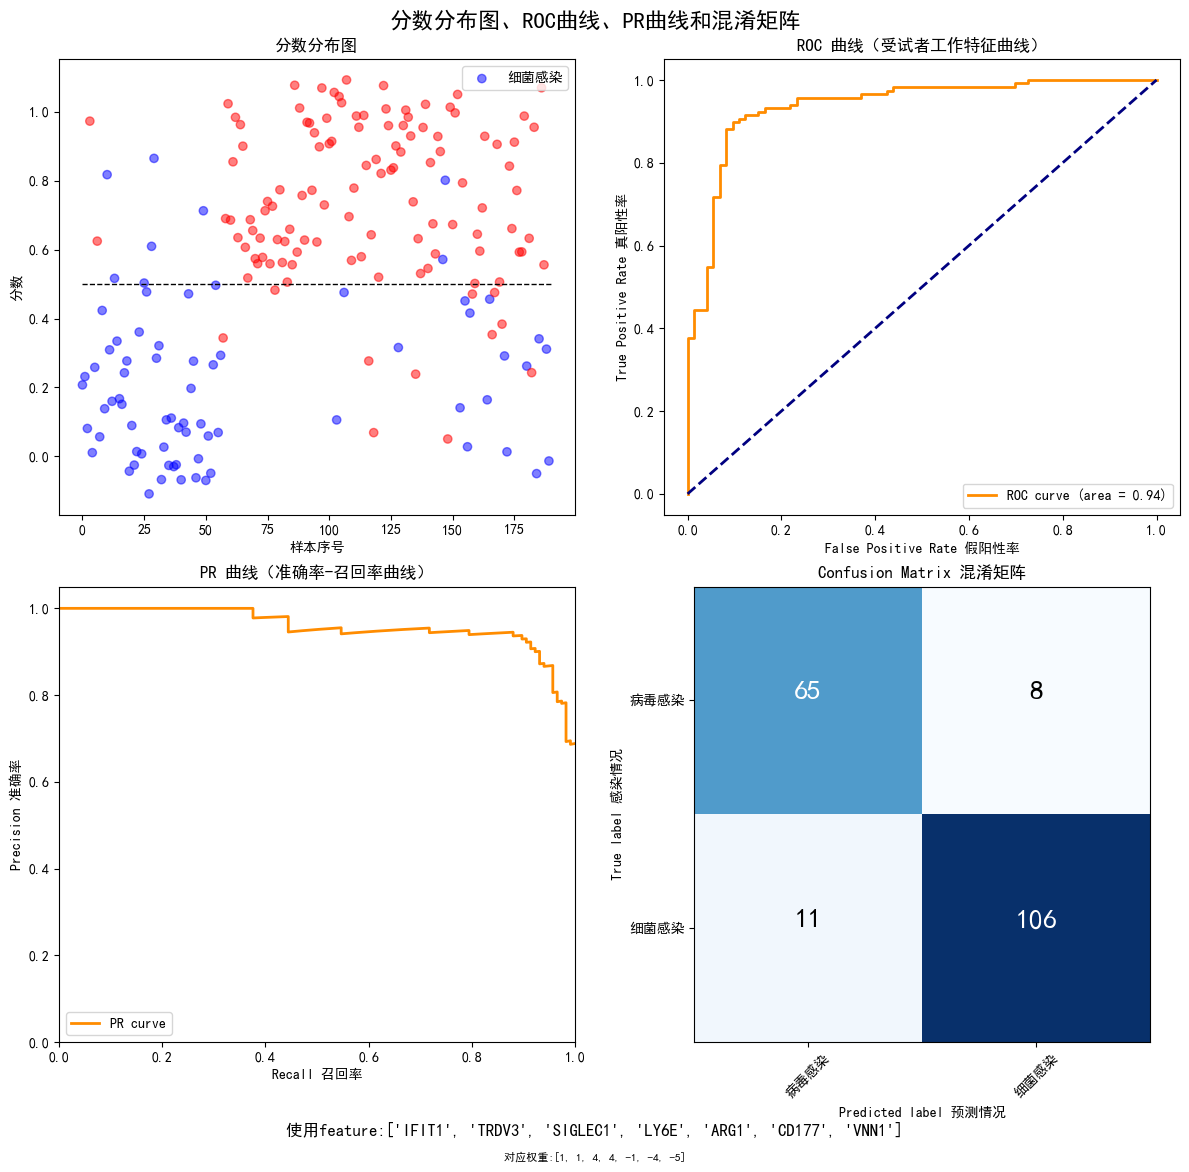

In [ ]:
test_data = gse_csv[gse_csv['infection_status'].isin(['viral', 'bacterial'])]
test_data['target'] = test_data['infection_status'].map({'viral': 1, 'bacterial': 0})

merge_2 = merge[merge['target'] != 'non-infectious illness'].copy()

viral_score = merge_2['up']
bacterial_score = merge_2['down']
target = merge_2['target'].map({'viral': 1, 'bacterial': 0})

# score is  viral_score - bacterial_score + 0.5
# viral_score,  bacterial_score and score are list.
score = np.array(viral_score) - np.array(bacterial_score) + 0.5

plot_all(
    score, 
    target,
    title="分数分布图、ROC曲线、PR曲线和混淆矩阵",
    feature=feature,
    weight=weight
)